# Multiclass Image Classification Model with Tensorflow

In [1]:
# Python Libraries
import re
from pathlib import Path
import sqlite3
import shutil

# Third-Party Libraries
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# Custom functions

In [2]:
# Create list of all dirs with files
base_dir = Path(Path.cwd().parent.parent, 'data', 'fotocasa')
subdirs = [path for path in base_dir.iterdir() if path.is_dir()]

# Create a list of files, if they have _ in the name means that they've been already labeled
files = [path for subdir in subdirs for path in subdir.iterdir() if (path.is_file()) & ('_' in path.stem)]

# Create List of roomType for each file
roomType = [re.findall(r'_roomType_(.*?)_', file.stem)[0] for file in files]

# Create directories for each of the concept
processed_data_dir = Path(Path.cwd().parent, 'data','processed_data')

# Create folder for storing roomType photos
roomType_dir = Path(processed_data_dir, 'roomType')

# # Create subdirectories based on each category if it doesn't exist
# for t in set(roomType):
#     Path(roomType_dir, t).mkdir(parents=True, exist_ok=True)

roomType_dir


WindowsPath('e:/1C Cursos/Data Science Part Time - The Bridge/DS/Proyecto/Entregable ML II/data/processed_data/roomType')

In [3]:
batch_size = 32
img_height, img_width = 128, 128

In [6]:
data_dir = roomType_dir

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3411 files belonging to 4 classes.
Using 2729 files for training.
Found 3411 files belonging to 4 classes.
Using 682 files for validation.


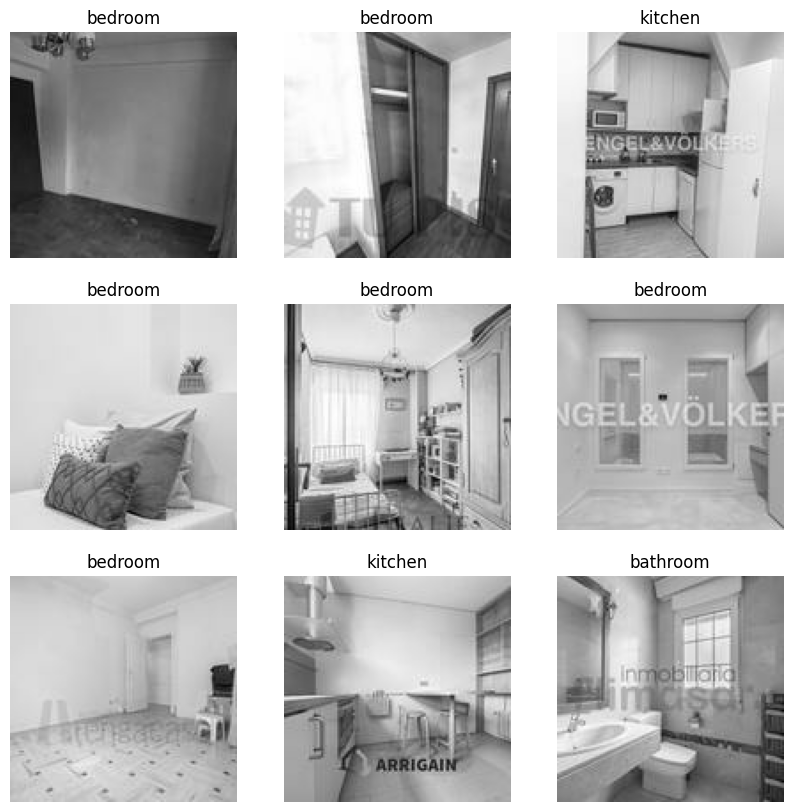

In [283]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

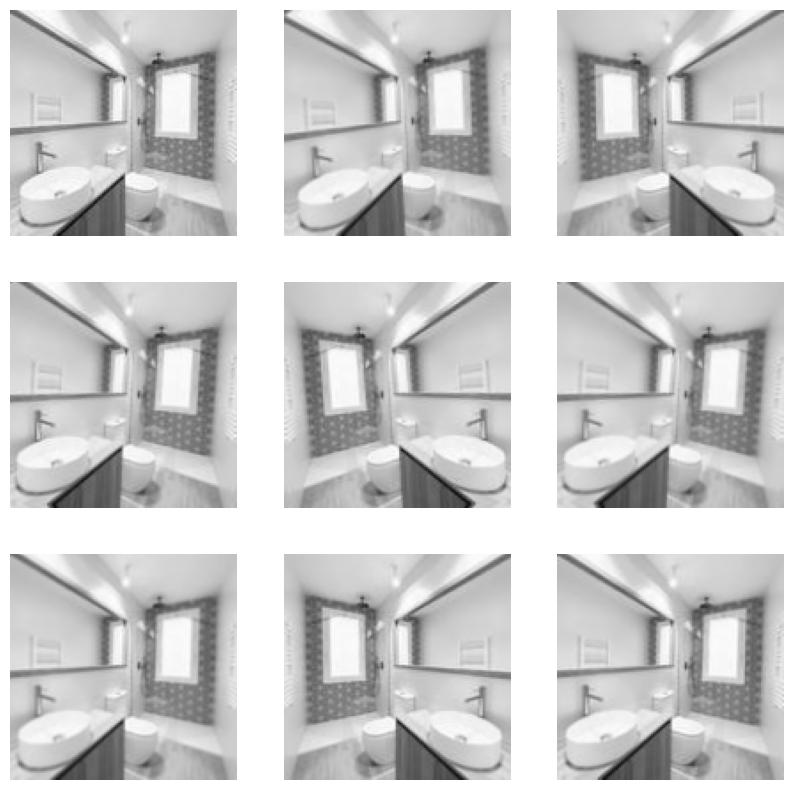

In [284]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
num_classes = len(class_names)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.01),
    layers.RandomZoom(0.01),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Custom Model

In [302]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16*2, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32*2, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64*2, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128*2, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer=Adam(learning_rate=0.0001),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_38 (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 rescaling_22 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 conv2d_75 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                

# Fit

In [303]:
epochs=30
with tf.device('/gpu:0'):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

Epoch 1/30


86/86 [==============================] - 45s 482ms/step - loss: 1.3196 - accuracy: 0.4005 - val_loss: 1.2308 - val_accuracy: 0.4633
Epoch 2/30
86/86 [==============================] - 37s 435ms/step - loss: 1.1960 - accuracy: 0.4760 - val_loss: 1.1499 - val_accuracy: 0.4765
Epoch 3/30
86/86 [==============================] - 39s 456ms/step - loss: 1.1353 - accuracy: 0.4936 - val_loss: 1.1303 - val_accuracy: 0.4751
Epoch 4/30
86/86 [==============================] - 39s 458ms/step - loss: 1.1006 - accuracy: 0.5255 - val_loss: 1.1158 - val_accuracy: 0.5088
Epoch 5/30
86/86 [==============================] - 38s 447ms/step - loss: 1.0514 - accuracy: 0.5625 - val_loss: 1.1305 - val_accuracy: 0.5220
Epoch 6/30
86/86 [==============================] - 37s 431ms/step - loss: 1.0179 - accuracy: 0.5757 - val_loss: 1.0553 - val_accuracy: 0.5455
Epoch 7/30
86/86 [==============================] - 37s 430ms/step - loss: 0.9550 - accuracy: 0.6189 - val_loss: 1.0441 - val_accuracy: 0.5543
Epoch 8/30

In [259]:
import pickle
modelfile = 'model_0.6.2.pickle'
with open(modelfile, 'wb') as handle:
    pickle.dump(model, handle)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
...layers\conv2d_3
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\flatten
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...layers\max_pooling2d_2
......vars
...layers\max_pooling2d_3
......vars
...layers\rescaling
......vars
...layers\sequential
......vars
...layers\sequential\layers\random_flip
......vars
...layers\sequential\layers\random_rotation
......vars
...layers\sequential\layers\random_zoom
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
..

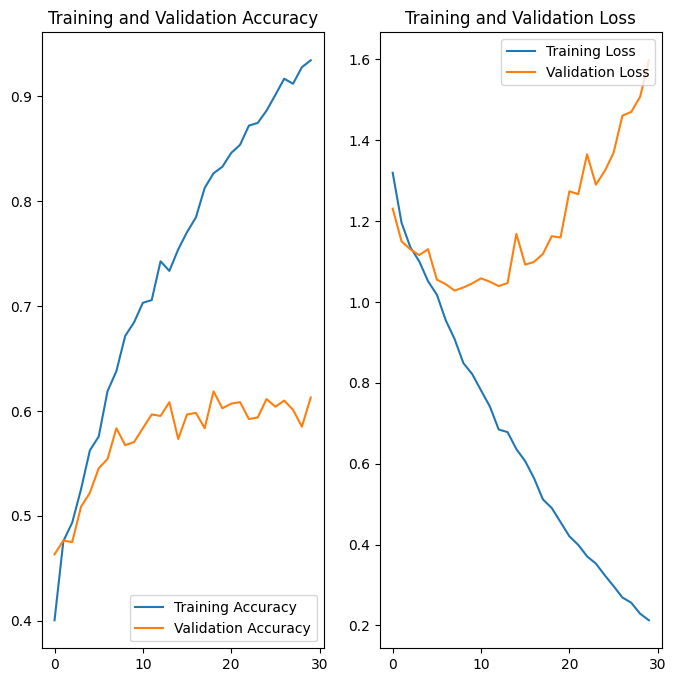

In [304]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [261]:
import numpy as np
for f in Path('test').iterdir():
    print(f.stem)
    img = tf.keras.utils.load_img(f, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    print('\n')

105031225__roomType_living-room__quality_medium_
1/1 [==============================] - 0s 83ms/step
This image most likely belongs to living-room with a 90.74 percent confidence.


105031243__roomType_bathroom__quality_medium_
1/1 [==============================] - 0s 30ms/step
This image most likely belongs to bathroom with a 88.66 percent confidence.


105031322__roomType_living-room__quality_medium_
1/1 [==============================] - 0s 27ms/step
This image most likely belongs to living-room with a 98.16 percent confidence.


105031425__roomType_bedroom__quality_medium_
1/1 [==============================] - 0s 26ms/step
This image most likely belongs to bedroom with a 81.66 percent confidence.


105031440__roomType_bathroom__quality_medium_
1/1 [==============================] - 0s 23ms/step
This image most likely belongs to bedroom with a 78.12 percent confidence.


105031459__roomType_bedroom__quality_medium_
1/1 [==============================] - 0s 29ms/step
This image mos

In [ ]:
test = r'E:\1C Cursos\Data Science Part Time - The Bridge\DS\Proyecto\Entregable ML II\data\processed_data\roomType\american-kitchen\444124524__roomType_american-kitchen__quality_medium_.jpg'

test = r'E:\1C Cursos\Data Science Part Time - The Bridge\DS\Proyecto\Entregable ML II\data\processed_data\roomType\bathroom\364874233__roomType_bathroom__quality_medium_.jpg'

test = r'E:\1C Cursos\Data Science Part Time - The Bridge\DS\Proyecto\484132687__roomType_living-room__quality_high__floor_wood_.jpg'

img = tf.keras.utils.load_img(test, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

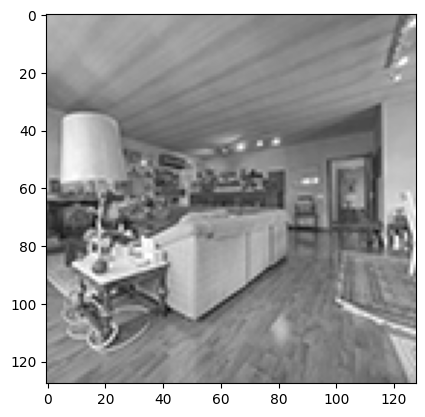

In [92]:
plt.imshow(img)

# Classify new dataset in order to have more training data
Everything is reviewed before passing it to train

In [30]:
import sys
sys.path.append(str(Path.cwd().parent))

from utils import image_processing

In [262]:
from io import BytesIO
def predict_image(model, file):
    byte_io = BytesIO()
    image_processing.process_img(file, (128,128)).save(byte_io, 'PNG')
    # plt.imshow(image_processing.process_img(file, (128,128)))
    img = tf.keras.utils.load_img(byte_io, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    class_name = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)
    print(f"This image {file.stem} most likely belongs to {class_name} with a {100 * np.max(score):.2f} percent confidence.")
    return class_name, confidence

In [277]:
# Create original dataset of images

# Create list of all dirs with files
base_dir = Path(Path.cwd().parent.parent, 'data', 'fotocasa', 'AUTO')
subdirs = [path for path in base_dir.iterdir() if path.is_dir()]

# Create a list of files, if they have _ in the name means that they've been already labeled
files = [path for subdir in subdirs for path in subdir.iterdir() if (path.is_file() & ('_' not in path.stem))]

len(files)

22

In [278]:
import os
for file in files:
    try:
        class_name, confidence = predict_image(model, file)
        if confidence > 90:
            new = Path(file.parent, f'{file.stem}__roomType_{class_name}_.jpg')
            file.rename(new)
    except Image.UnidentifiedImageError:
        os.remove(file)
        print(f'Removed {file}')


Removed e:\1C Cursos\Data Science Part Time - The Bridge\DS\Proyecto\data\fotocasa\AUTO\165521663\.jpg
1/1 [==============================] - 0s 79ms/step
This image 529626625 most likely belongs to living-room with a 100.00 percent confidence.
1/1 [==============================] - 0s 22ms/step
This image 529626627 most likely belongs to living-room with a 100.00 percent confidence.
1/1 [==============================] - 0s 23ms/step
This image 529626637 most likely belongs to kitchen with a 96.04 percent confidence.
1/1 [==============================] - 0s 41ms/step
This image 529626687 most likely belongs to bathroom with a 90.38 percent confidence.
1/1 [==============================] - 0s 25ms/step
This image 529626732 most likely belongs to bedroom with a 100.00 percent confidence.
1/1 [==============================] - 0s 24ms/step
This image 529626736 most likely belongs to living-room with a 100.00 percent confidence.
1/1 [==============================] - 0s 25ms/step
This i

# Xception

In [10]:
import cv2
import numpy as np

In [7]:
subdirs = [path for path in data_dir.iterdir() if path.is_dir()]

files, data_img, category = [], [], []

for directory in subdirs:
    for file in directory.iterdir():
        if file.is_file():
            category.append(directory.name)
            files.append(file)
            data_img.append(cv2.imread(str(file)))

In [8]:
df = pd.DataFrame({'file':files,'target':category})
df

,file,target
0,e:\1C Cursos\Data Science Part Time - The Brid...,bathroom
1,e:\1C Cursos\Data Science Part Time - The Brid...,bathroom
2,e:\1C Cursos\Data Science Part Time - The Brid...,bathroom
3,e:\1C Cursos\Data Science Part Time - The Brid...,bathroom
4,e:\1C Cursos\Data Science Part Time - The Brid...,bathroom
...,...,...
3406,e:\1C Cursos\Data Science Part Time - The Brid...,living-room
3407,e:\1C Cursos\Data Science Part Time - The Brid...,living-room
3408,e:\1C Cursos\Data Science Part Time - The Brid...,living-room
3409,e:\1C Cursos\Data Science Part Time - The Brid...,living-room


In [11]:
# Converting list to numpy array
X = np.array(data_img)

In [12]:
from sklearn.preprocessing import OneHotEncoder

y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(df['target'].values.reshape(-1,1))

c:\Users\alex\miniconda3\envs\ds0\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
print('Shape of y: ', y.shape)


Shape of y:  (3411, 4)


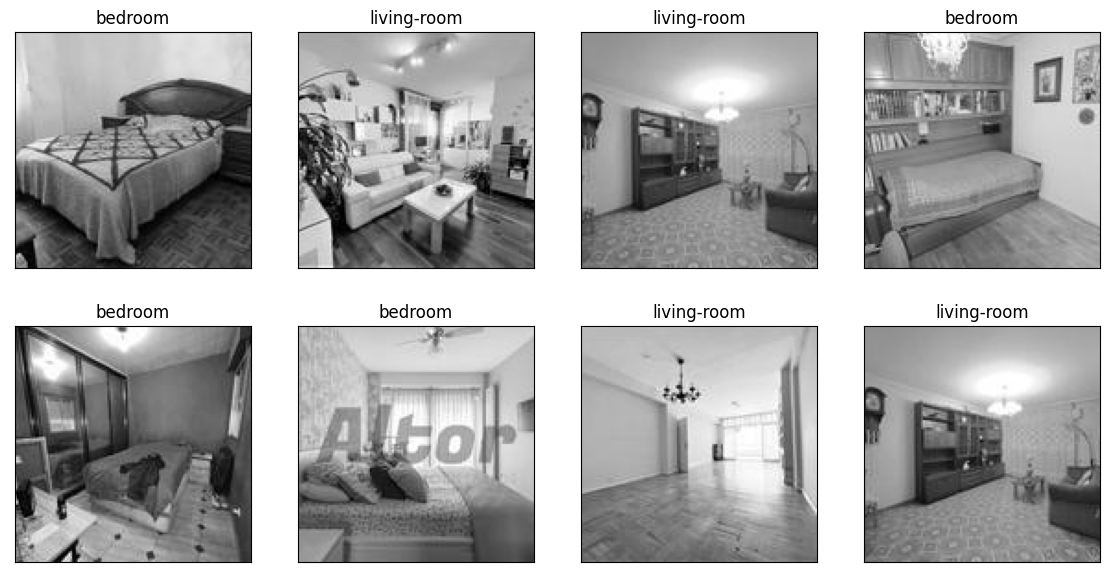

In [14]:
indices = np.random.randint(0,X.shape[0],8) 
i = 1
plt.figure(figsize=(14,7))
for each in indices:
    plt.subplot(2,4,i)
    plt.imshow(X[each])
    plt.title(df['target'].loc[each])
    plt.xticks([])
    plt.yticks([])
    i += 1

In [15]:
from sklearn.model_selection import train_test_split

X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)

X_train shape:  (2319, 128, 128, 3)
y_train shape:  (2319, 4)
X_val shape  :  (580, 128, 128, 3)
y_val shape  :  (580, 4)
X_test shape :  (512, 128, 128, 3)
y_test shape :  (512, 4)


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)

validation_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)

train_gen.fit(X_train)
validation_gen.fit(X_val)

In [21]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

# Defining batch and epoch sizes
batch_size = 100
epochs = 15

# Defining the pretrained base model
base = Xception(include_top=False, weights='imagenet', input_shape=(128,128,3))
x = base.output
x = GlobalAveragePooling2D()(x)
# Defining the head of the model where the prediction is conducted
head = Dense(4, activation='softmax')(x)
# Combining base and head 
model = Model(inputs=base.input, outputs=head)

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

In [23]:
with tf.device('/gpu:0'):
    # Fitting the model with train and validation augmented datasets.
    history = model.fit(train_gen.flow(X_train, y_train, batch_size=batch_size),
                                epochs = epochs,
                                validation_data = validation_gen.flow(X_val, y_val, batch_size=batch_size),
                                steps_per_epoch = X_train.shape[0] // batch_size)

Epoch 1/15
23/23 [==============================] - 233s 10s/step - loss: 1.1038 - accuracy: 0.5493 - val_loss: 2.1429 - val_accuracy: 0.4190
Epoch 2/15
23/23 [==============================] - 232s 10s/step - loss: 0.9517 - accuracy: 0.6246 - val_loss: 1.7111 - val_accuracy: 0.4293
Epoch 3/15
23/23 [==============================] - 231s 10s/step - loss: 0.8918 - accuracy: 0.6467 - val_loss: 1.4144 - val_accuracy: 0.5224
Epoch 4/15
23/23 [==============================] - 222s 10s/step - loss: 0.7803 - accuracy: 0.6877 - val_loss: 1.1656 - val_accuracy: 0.6103
Epoch 5/15
23/23 [==============================] - 225s 10s/step - loss: 0.7436 - accuracy: 0.6972 - val_loss: 1.1069 - val_accuracy: 0.6310
Epoch 6/15
23/23 [==============================] - 226s 10s/step - loss: 0.7034 - accuracy: 0.7187 - val_loss: 0.9380 - val_accuracy: 0.6552
Epoch 7/15
23/23 [==============================] - 221s 10s/step - loss: 0.6802 - accuracy: 0.7323 - val_loss: 0.8217 - val_accuracy: 0.6983
Epoch 

In [49]:
import pickle
modelfile = 'model_xception_0.pickle'
with open(modelfile, 'wb') as handle:
    pickle.dump(model, handle)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\activation
......vars
...layers\activation_1
......vars
...layers\activation_10
......vars
...layers\activation_11
......vars
...layers\activation_12
......vars
...layers\activation_13
......vars
...layers\activation_14
......vars
...layers\activation_15
......vars
...layers\activation_16
......vars
...layers\activation_17
......vars
...layers\activation_18
......vars
...layers\activation_19
......vars
...layers\activation_2
......vars
...layers\activation_20
......vars
...layers\activation_21
......vars
...layers\activation_22
......vars
...layers\activation_23
......vars
...layers\activation_24
......vars
...layers\activation_25
......vars
...layers\activation_26
......vars
...layers\activation_27
......vars
...layers\activation_28
......vars
...layers\activation_29
......vars
...layers\activation_3
......vars
...layers\activation_30
......vars
...layers\activation_31
......vars
...layers\activation_32
......

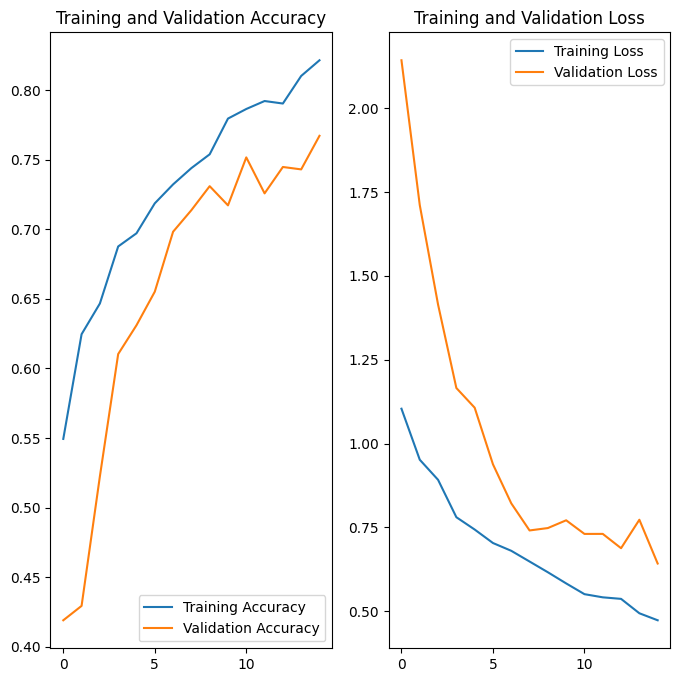

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

16/16 [==============================] - 9s 495ms/step


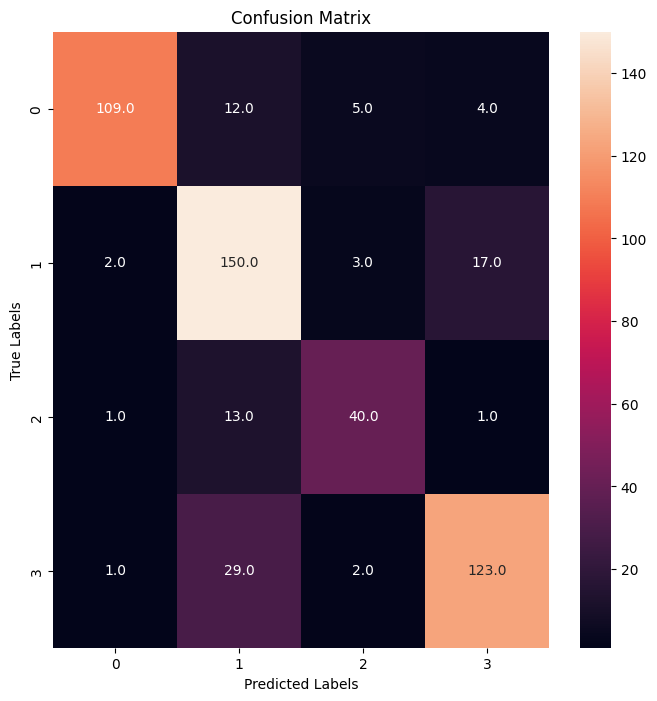

In [25]:
# Predicting Test Dataset

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predicting labels from X_test data
y_pred = model.predict(X_test)

# Converting prediction classes from one hot encoding to list
# Argmax returns the position of the largest value
y_pred_classes = np.argmax(y_pred, axis = 1)

# Convert test labels from one hot encoding to list
y_test_classes = np.argmax(y_test, axis = 1)

# Create the confusion matrix
confmx = confusion_matrix(y_test_classes, y_pred_classes)
f, ax = plt.subplots(figsize = (8,8))
sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show();

In [26]:
# Printing the model scores:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       130
           1       0.74      0.87      0.80       172
           2       0.80      0.73      0.76        55
           3       0.85      0.79      0.82       155

    accuracy                           0.82       512
   macro avg       0.84      0.81      0.82       512
weighted avg       0.83      0.82      0.83       512



## Predict other images

In [ ]:
subdirs = [path for path in data_dir.iterdir() if path.is_dir()]

files, data_img, category = [], [], []

for directory in subdirs:
    for file in directory.iterdir():
        if file.is_file():
            category.append(directory.name)
            files.append(file)
            data_img.append(cv2.imread(str(file)))

In [34]:
im = r'E:\1C Cursos\Data Science Part Time - The Bridge\DS\Proyecto\data\fotocasa\AUTO II\165523247\530924234.jpg'



sample_img_data = cv2.imread(str(im))
type(sample_img_data)

numpy.ndarray

In [33]:
type(image_processing.process_img(file, (128,128)))

PIL.Image.Image

In [58]:
new_files = [file for file in Path('test').iterdir() if file.is_file()]
new_files

[WindowsPath('test/105031225__roomType_living-room__quality_medium_.jpg'),
 WindowsPath('test/105031243__roomType_bathroom__quality_medium_.jpg'),
 WindowsPath('test/105031322__roomType_living-room__quality_medium_.jpg'),
 WindowsPath('test/105031425__roomType_bedroom__quality_medium_.jpg'),
 WindowsPath('test/105031440__roomType_bathroom__quality_medium_.jpg'),
 WindowsPath('test/105031459__roomType_bedroom__quality_medium_.jpg'),
 WindowsPath('test/364874231__roomType_kitchen__quality_homestaging_.jpg'),
 WindowsPath('test/378907011__roomType_kitchen__quality_medium__floor_tile_.jpg'),
 WindowsPath('test/531977290.jpg'),
 WindowsPath('test/531977319.jpg'),
 WindowsPath('test/532613052.jpg'),
 WindowsPath('test/538937271.jpg')]

In [59]:
sample_img_data = []
for file in new_files:
    # sample_img_data.append(np.asarray(image_processing.process_img(file, (128,128))))
    sample_img_data.append(cv2.imread(str(file)))

# Converting list to numpy array
sample_img_data = np.array(sample_img_data)
print('Shape of X: ', sample_img_data.shape)

Shape of X:  (12, 128, 128, 3)


In [60]:
categories = [subdir.name for subdir in subdirs]
categories

['bathroom', 'bedroom', 'kitchen', 'living-room']

In [ ]:
# Predicting random 5 images
sample_pred = model.predict(sample_img_data)
sample_classes = np.argmax(sample_pred, axis = 1)

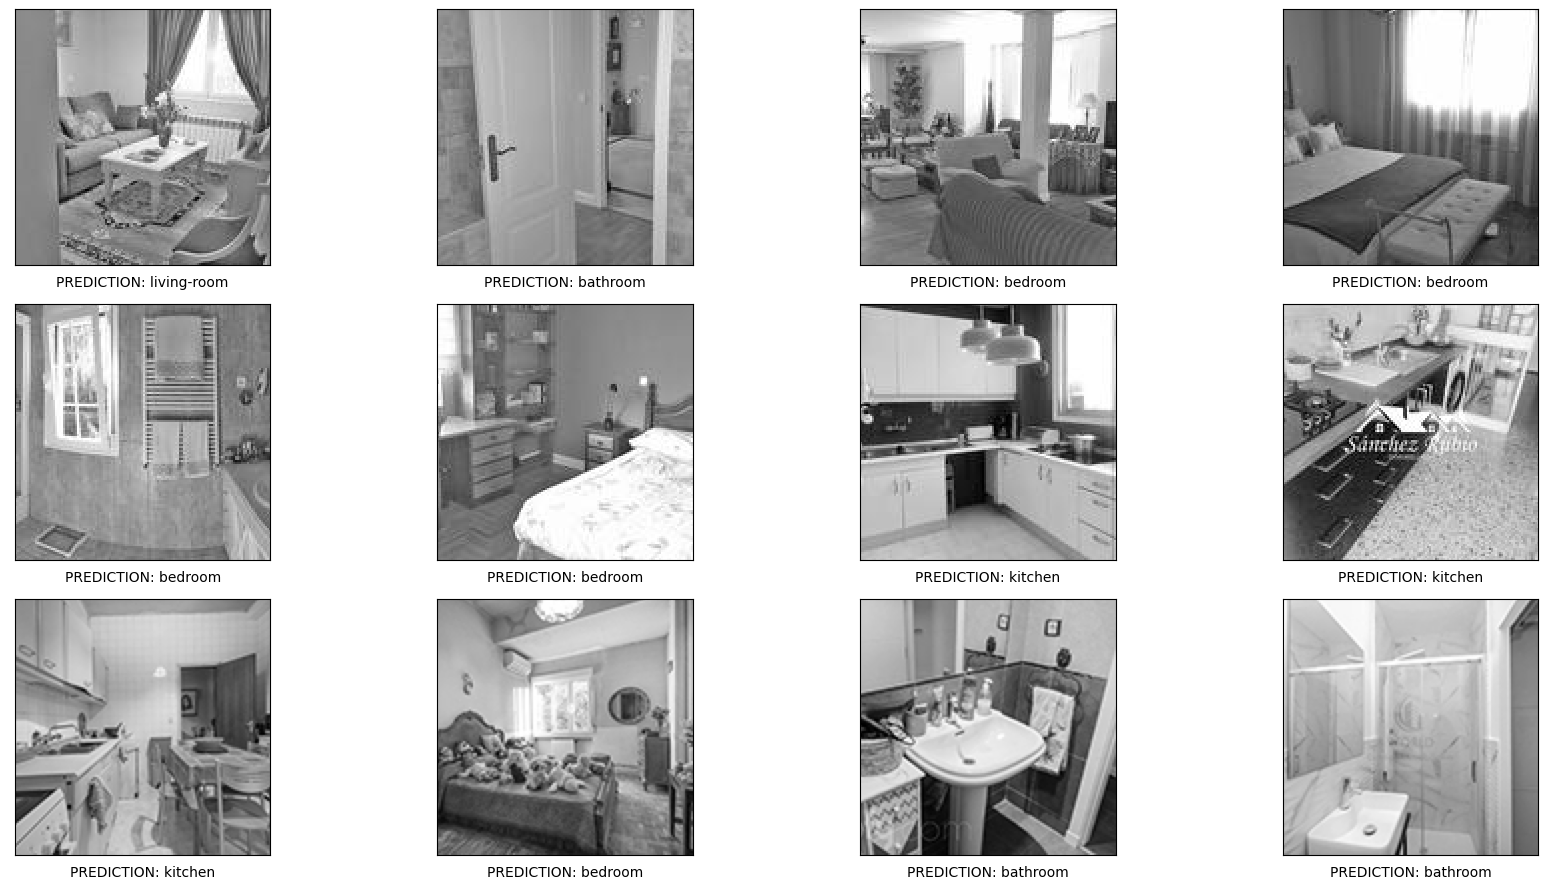

In [63]:
# Visualizing the predictions
i = 0
plt.figure(figsize=(18,9))
for each in range(sample_img_data.shape[0]):
    i += 1
    plt.subplot(3,4,i)
    plt.imshow(sample_img_data[each])
    plt.xlabel('PREDICTION: ' + str(categories[sample_classes[each]]))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()